As discussed in the discussion forums (https://www.kaggle.com/c/career-con-2019/discussion/87239#latest-508136) it looks as if each series is part of longer aquisition periods that have been cut up into chunks with 128 samples.

This means that each series is not truely independent and there is leakage between them via the orientation data. Therefore if you have any features that use orientation, you will get a very high CV score due to this leakage in the train set.

This kernel will show you how it is possible to get a CV score of 0.992 using only the orientation data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm_notebook
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, pairwise_distances, pairwise_distances_argmin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupShuffleSplit, StratifiedShuffleSplit, GroupKFold
from sklearn.neighbors import NearestNeighbors

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


In [2]:
train = pd.read_csv('../input/X_train.csv')
y = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')
sub = pd.read_csv('../input/sample_submission.csv')

# Get the start and end orientations
We'll create features that represent the start and end orientations (and Euler angles) of the robot

In [3]:
def get_start_end_points(data):
    start = data.query("measurement_number==0").reset_index()
    end = data.query("measurement_number==127").reset_index()

    columns = ["orientation_X", "orientation_Y", "orientation_Z", "orientation_W"]
    
    start, end = start[columns], end[columns]

    points = start.join(end, lsuffix="_start", rsuffix="_end").join(y)
    return points

In [4]:
train_points = get_start_end_points(train)
test_points = get_start_end_points(test)

train_points.head()

,orientation_X_start,orientation_Y_start,orientation_Z_start,orientation_W_start,orientation_X_end,orientation_Y_end,orientation_Z_end,orientation_W_end,series_id,group_id,surface
0,-0.75853,-0.63435,-0.104880,-0.105970,-0.75953,-0.63306,-0.104610,-0.106840,0,13,fine_concrete
1,-0.95896,0.24074,0.030758,-0.146610,-0.95864,0.24230,0.031996,-0.145870,1,31,concrete
2,-0.50944,-0.84779,-0.129460,-0.070378,-0.51434,-0.84490,-0.128560,-0.071282,2,20,concrete
3,-0.93940,0.31003,0.038299,-0.141230,-0.93902,0.31147,0.038584,-0.140510,3,31,concrete
4,-0.88673,0.43740,0.061771,-0.136300,-0.89689,0.41646,0.058247,-0.136950,4,22,soft_tiles


# Use nearest neighbours to find similar series
We'll compare the start of each series to the end of every other. We'll also to the reverse and pick the match with the smallest distance

In [5]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

Fold 0, score: 0.98961, mean distance 0.00049
Fold 1, score: 0.98958, mean distance 0.00053
Fold 2, score: 0.99739, mean distance 0.00048
Fold 3, score: 0.98691, mean distance 0.00047
Fold 4, score: 0.98950, mean distance 0.00061
Fold 5, score: 0.99213, mean distance 0.00051
Fold 6, score: 0.99738, mean distance 0.00043
Fold 7, score: 0.99208, mean distance 0.00049
Fold 8, score: 0.99206, mean distance 0.00053
Fold 9, score: 0.99202, mean distance 0.00051
Average accuracy 0.99187


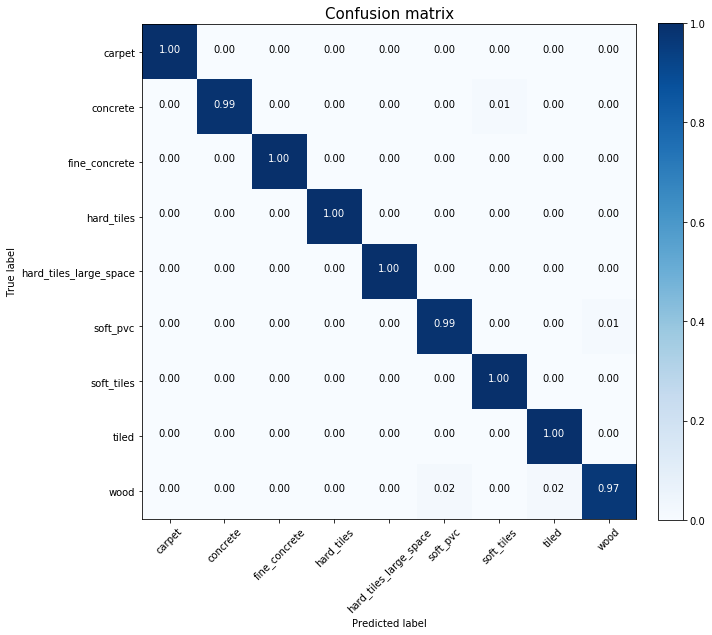

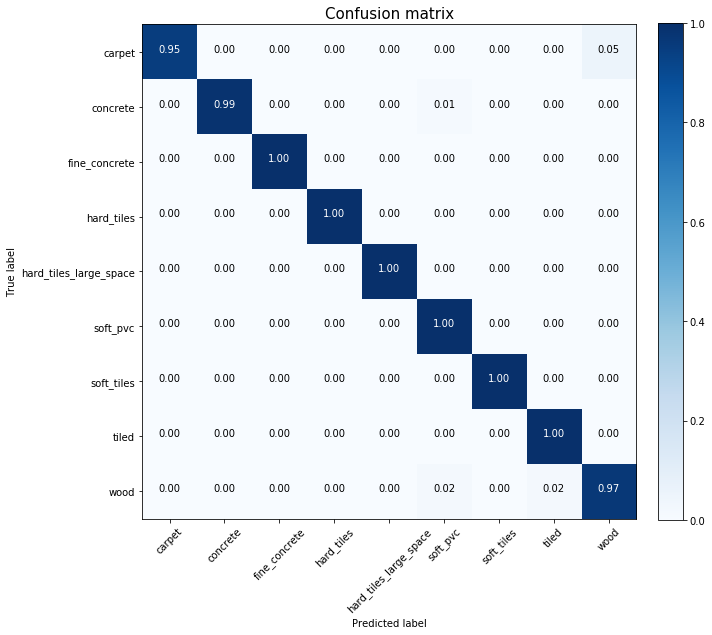

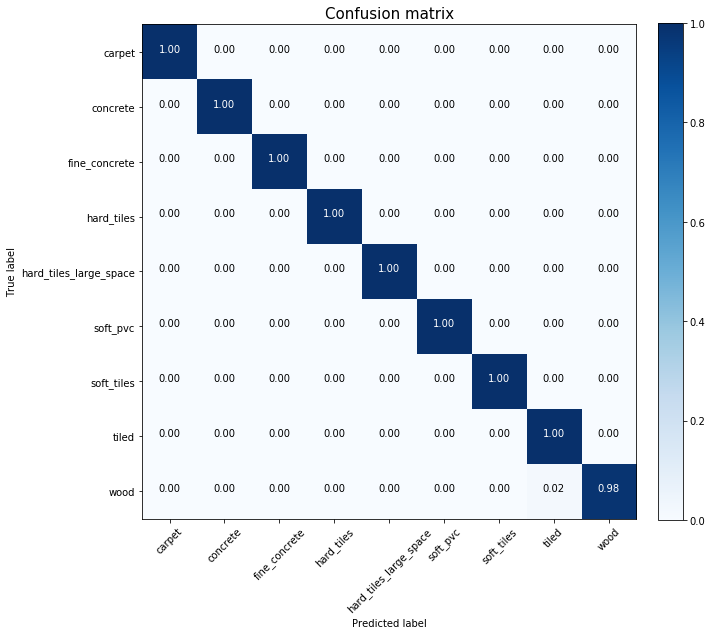

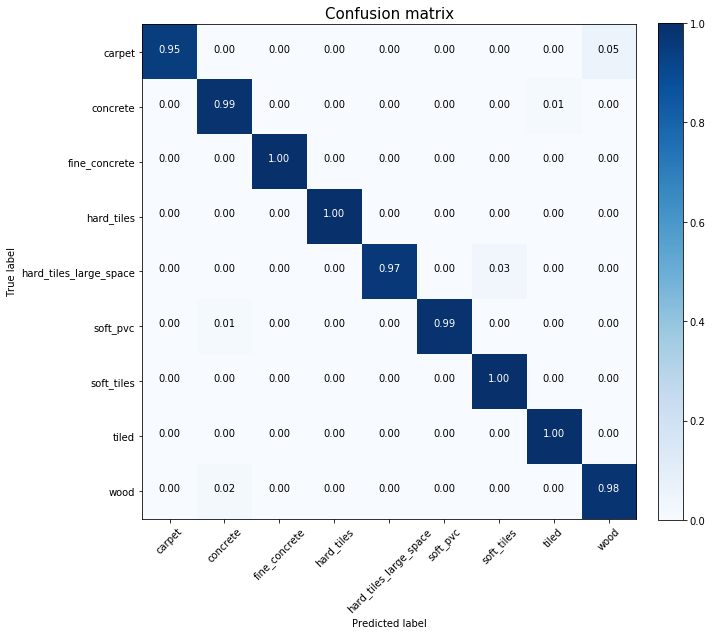

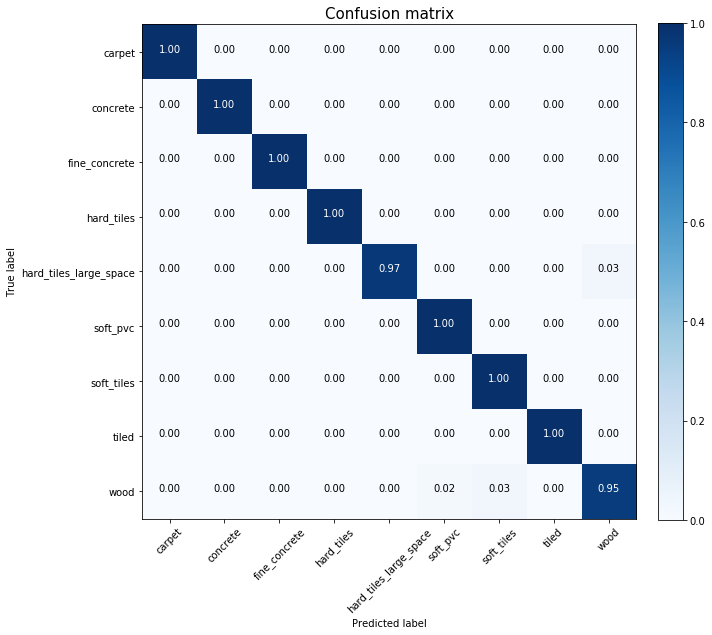

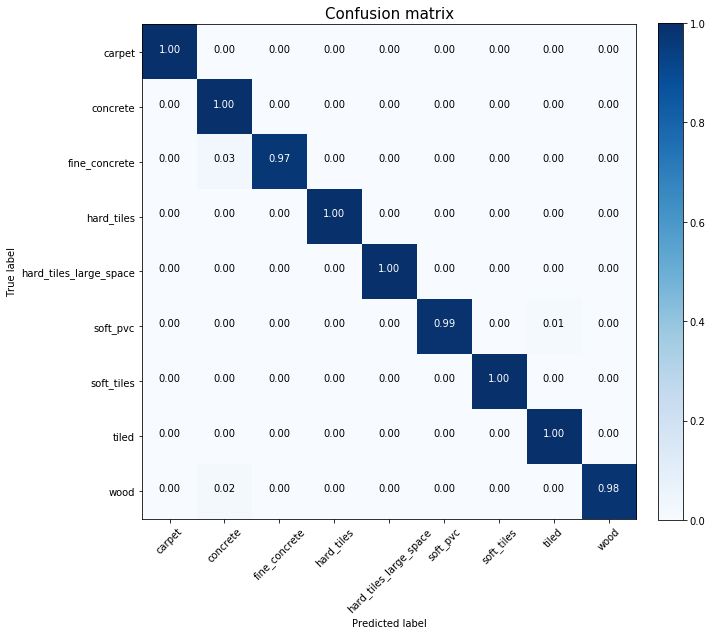

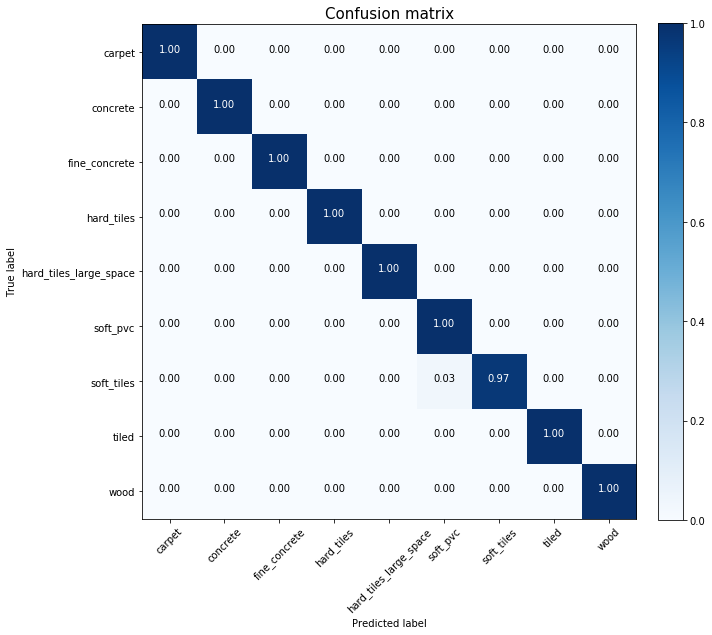

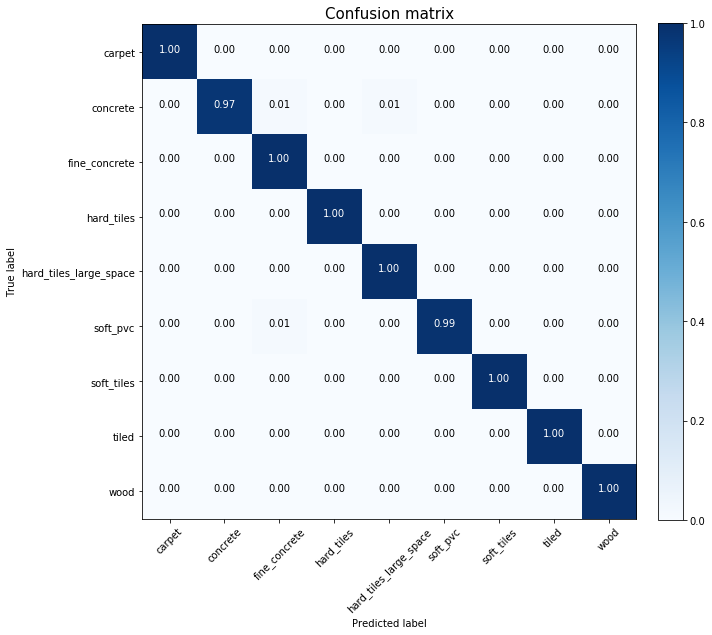

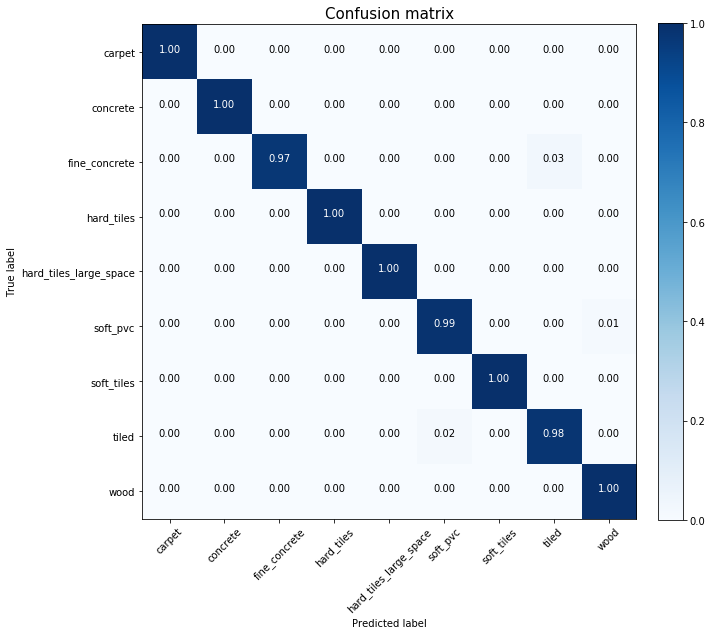

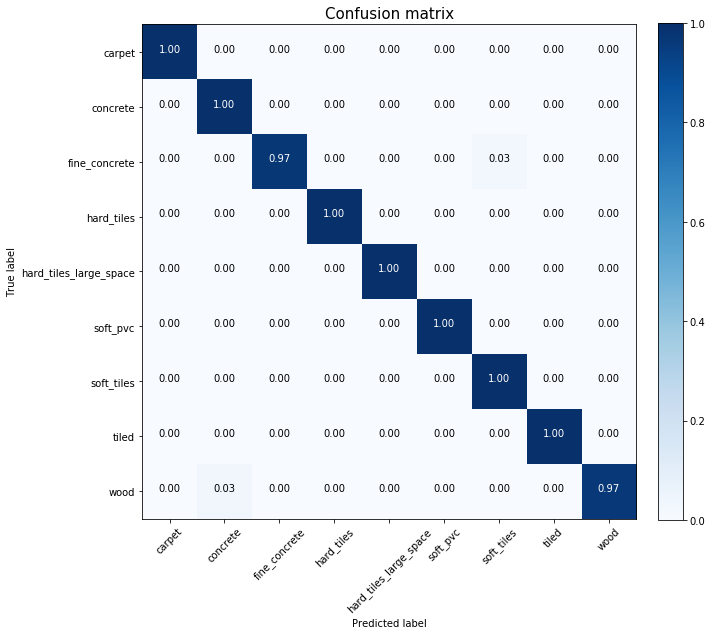

In [6]:
le = LabelEncoder()
y['surface'] = le.fit_transform(y['surface'])
scores = []

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (trn_idx, val_idx) in enumerate(folds.split(train_points.values, y['surface'].values)):
    # Compare start to end, and end to start
    x_train_se, x_valid_se = train_points.iloc[trn_idx].filter(regex='start'), train_points.iloc[val_idx].filter(regex='end')
    x_train_es, x_valid_es = train_points.iloc[trn_idx].filter(regex='end'), train_points.iloc[val_idx].filter(regex='start')

    y_train, y_valid = y["surface"][trn_idx], y["surface"][val_idx],
        
    neigh = NearestNeighbors(1)
    
    neigh.fit(x_train_se)
    distances_se, indices_se = neigh.kneighbors(x_valid_se)
    
    neigh.fit(x_train_es)
    distances_es, indices_es = neigh.kneighbors(x_valid_es)
    
    # Find the minimum distance to select the nearest match
    distances = np.concatenate([distances_se, distances_es], -1)
    indices = np.concatenate([indices_se, indices_es], -1)    
    indices_best = np.array([indices[i, x] for i, x in enumerate(np.argmin(distances, axis=1))])
    
    indices = indices_best.flatten()
    accuracy = accuracy_score(y_valid, y_train.iloc[indices])
    scores.append(accuracy)
    print("Fold %i, score: %0.5f, mean distance %0.5f" % (fold, accuracy, np.mean(distances)))
    
    plot_confusion_matrix(y_valid, y_train.iloc[indices], le.classes_, normalize=True)
    
print("Average accuracy %0.5f" % np.mean(scores))

# Discussion
As you can see it's possible to get a CV score of 0.992 using only orientation data due to the leakage in the train set. This is why it's very difficult to get a reliable CV score that matches the public LB.

As far as I can tell this doesn't help much with the test dataset (creating a submission using this method scores 0.32), but that doesn't mean you can't use the methods in this kernel to help with your predictions